In [ ]:
!pip install --upgrade yfinance

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 44.8 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pennylane as qml
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set default tensor type to ensure consistency
torch.set_default_dtype(torch.float32)

# Define quantum device (simulator)
n_qubits = 4  # Reduced to avoid computational intensity
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit template for VQC - simplified to improve stability
@qml.qnode(dev, interface='torch')
def vqc_block(inputs, weights):
    # Data encoding layer - simplified
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RY(inputs[i % len(inputs)], wires=i)  # Removed arctan to avoid exploding gradients

    # Single variational layer instead of two
    for i in range(n_qubits):
        qml.RX(weights[0, i, 0], wires=i)
        qml.RY(weights[0, i, 1], wires=i)

    # Entanglement - reduced complexity
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i, i+1])

    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define QLSTM Cell
class QLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(QLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim

        # Weight initializer helper
        def init_weights():
            # Small initial weights to prevent NaN issues
            return nn.Parameter(torch.randn(1, n_qubits, 3, dtype=torch.float32) * 0.1)

        # One set of weights for all gates to reduce complexity
        self.forget_weights = init_weights()
        self.input_weights = init_weights()
        self.cell_weights = init_weights()
        self.output_weights = init_weights()
        self.pred_weights = init_weights()

        # Linear layers with gradient clipping
        self.input_projection = nn.Linear(input_dim + hidden_dim, n_qubits)

    def forward(self, x, h_prev, c_prev):
        # Ensure correct types
        x = x.to(torch.float32)
        h_prev = h_prev.to(torch.float32)
        c_prev = c_prev.to(torch.float32)

        # Concatenate and project
        combined = torch.cat((h_prev, x), dim=1)
        v_t = self.input_projection(combined)

        # Normalize to prevent extreme values
        v_t = torch.nn.functional.normalize(v_t, dim=1) * 0.5
        v_t_np = v_t.detach().cpu().numpy().astype(np.float32)

        # Run quantum circuits with error handling
        try:
            # Forget gate
            f_t = torch.sigmoid(torch.tensor(vqc_block(v_t_np[0], self.forget_weights),
                                            dtype=torch.float32).unsqueeze(0))

            # Input gate - add dropout for regularization
            i_t = torch.sigmoid(torch.tensor(vqc_block(v_t_np[0], self.input_weights),
                                           dtype=torch.float32).unsqueeze(0)) * 0.9

            # Cell state candidate
            C_tilde_t = torch.tanh(torch.tensor(vqc_block(v_t_np[0], self.cell_weights),
                                              dtype=torch.float32).unsqueeze(0))

            # Update cell state with gradient clipping
            c_t = torch.clamp(f_t * c_prev + i_t * C_tilde_t, -3, 3)

            # Output gate
            o_t = torch.sigmoid(torch.tensor(vqc_block(v_t_np[0], self.output_weights),
                                           dtype=torch.float32).unsqueeze(0))

            # Hidden state
            h_t = o_t * torch.tanh(c_t)

            # Prediction
            y_t = torch.tensor(vqc_block(v_t_np[0], self.pred_weights),
                             dtype=torch.float32).unsqueeze(0)

            # Reshape to match expected dimensions
            y_t = y_t.reshape(1, n_qubits)

            return y_t, h_t, c_t

        except Exception as e:
            print(f"Error in quantum circuit: {e}")
            # Fallback to classical computation if quantum circuit fails
            return torch.zeros(1, n_qubits), h_prev, c_prev

# Define QLSTM Model
class QLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(QLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.qlstm_cell = QLSTMCell(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # Add batch norm for stability
        self.batch_norm = nn.BatchNorm1d(hidden_dim)

    def forward(self, x):
        # Process one sequence at a time to avoid batch processing issues
        all_outputs = []

        for b in range(x.size(0)):
            h = torch.zeros(1, self.hidden_dim, dtype=torch.float32)
            c = torch.zeros(1, self.hidden_dim, dtype=torch.float32)

            for t in range(x.size(1)):
                # Process one step at a time
                x_t = x[b, t, :].unsqueeze(0)  # Add batch dimension
                y, h, c = self.qlstm_cell(x_t, h, c)

            # Use only the final output
            all_outputs.append(y)

        # Stack all batch outputs
        combined_output = torch.cat(all_outputs, dim=0)

        # Apply batch normalization for stability
        if combined_output.size(0) > 1:  # Only apply if batch size > 1
            combined_output = self.batch_norm(combined_output)

        # Final prediction
        return self.fc(combined_output)


In [ ]:
# Fetch and preprocess data
ticker = "AAPL"
data = yf.download(ticker, start="2014-01-01", end="2020-01-01")

# Handle NaN values
data = data.dropna()

# Select features and normalize
features = ['Close', 'Volume']
scaler = MinMaxScaler(feature_range=(0, 1))  # Reduced range to improve stability
scaled_data = scaler.fit_transform(data[features])

# Create sequences with smaller window
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length, 0])  # Predict 'Close' price
    return np.array(xs), np.array(ys)

seq_length = 5  # Reduced sequence length
X, y = create_sequences(scaled_data, seq_length)

# Split data (80-20)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train.astype(np.float32))
y_train = torch.FloatTensor(y_train.astype(np.float32))
X_test = torch.FloatTensor(X_test.astype(np.float32))
y_test = torch.FloatTensor(y_test.astype(np.float32))

# Create smaller batches for training
def create_batches(x, y, batch_size=32):
    batches = []
    for i in range(0, len(x), batch_size):
        end = min(i + batch_size, len(x))
        batches.append((x[i:end], y[i:end]))
    return batches

batch_size = 16  # Small batch size
train_batches = create_batches(X_train, y_train, batch_size)


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
# Hyperparameters
input_dim = len(features)  # Now 2 (Close, Volume)
hidden_dim = n_qubits  # Match n_qubits
output_dim = 1
epochs = 20
learning_rate = 0.001

# Initialize model, loss, optimizer
model = QLSTM(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added weight decay

# Training loop with modifications for stability
for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch_x, batch_y in train_batches:
        optimizer.zero_grad()

        try:
            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y)

            # Check for NaN loss
            if torch.isnan(loss).item():
                print("NaN loss detected, skipping batch")
                continue

            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            epoch_loss += loss.item()

        except Exception as e:
            print(f"Error in batch: {e}")
            continue

    avg_loss = epoch_loss / len(train_batches) if train_batches else float('nan')
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}')

Epoch 1/20, Loss: 0.398555
Epoch 2/20, Loss: 0.160773
Epoch 3/20, Loss: 0.076414
Epoch 4/20, Loss: 0.058375
Epoch 5/20, Loss: 0.053882
Epoch 6/20, Loss: 0.051259
Epoch 7/20, Loss: 0.048917
Epoch 8/20, Loss: 0.046771
Epoch 9/20, Loss: 0.044839
Epoch 10/20, Loss: 0.043116
Epoch 11/20, Loss: 0.041587
Epoch 12/20, Loss: 0.040231
Epoch 13/20, Loss: 0.039029
Epoch 14/20, Loss: 0.037968
Epoch 15/20, Loss: 0.037033
Epoch 16/20, Loss: 0.036207
Epoch 17/20, Loss: 0.035475
Epoch 18/20, Loss: 0.034827
Epoch 19/20, Loss: 0.034252
Epoch 20/20, Loss: 0.033742


MSE: 711.05, MAE: 22.56, R²: -9.19


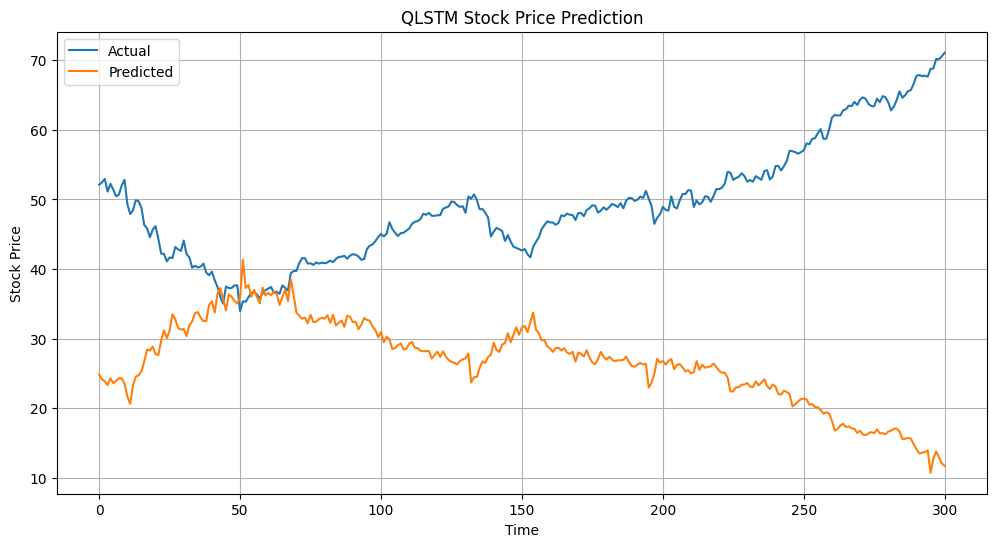

In [ ]:
# Evaluation with proper dimensions
model.eval()
with torch.no_grad():
    # Process in smaller batches to avoid memory issues
    train_predictions = []
    for i in range(0, len(X_train), batch_size):
        batch = X_train[i:i+batch_size]
        preds = model(batch).squeeze().detach().cpu().numpy()
        train_predictions.extend(preds)

    test_predictions = []
    for i in range(0, len(X_test), batch_size):
        batch = X_test[i:i+batch_size]
        preds = model(batch).squeeze().detach().cpu().numpy()
        test_predictions.extend(preds)

# Convert to numpy arrays
train_predictions = np.array(train_predictions).reshape(-1, 1)
test_predictions = np.array(test_predictions).reshape(-1, 1)
y_train_np = y_train.numpy().reshape(-1, 1)
y_test_np = y_test.numpy().reshape(-1, 1)

# Create arrays for inverse transform
train_pred_full = np.zeros((len(train_predictions), len(features)))
train_pred_full[:, 0] = train_predictions.flatten()  # First column is the predicted Close
test_pred_full = np.zeros((len(test_predictions), len(features)))
test_pred_full[:, 0] = test_predictions.flatten()  # First column is the predicted Close

y_train_full = np.zeros((len(y_train_np), len(features)))
y_train_full[:, 0] = y_train_np.flatten()  # First column is the actual Close
y_test_full = np.zeros((len(y_test_np), len(features)))
y_test_full[:, 0] = y_test_np.flatten()  # First column is the actual Close

# Inverse transform
train_pred_inv = scaler.inverse_transform(train_pred_full)[:, 0]  # Extract only Close column
test_pred_inv = scaler.inverse_transform(test_pred_full)[:, 0]  # Extract only Close column
y_train_actual = scaler.inverse_transform(y_train_full)[:, 0]  # Extract only Close column
y_test_actual = scaler.inverse_transform(y_test_full)[:, 0]  # Extract only Close column

# Calculate metrics
mse = mean_squared_error(y_test_actual, test_pred_inv)
mae = mean_absolute_error(y_test_actual, test_pred_inv)
r2 = r2_score(y_test_actual, test_pred_inv)
print(f'MSE: {mse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(test_pred_inv, label='Predicted')
plt.title('QLSTM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()